In [1]:
# Import required libraries
import pandas as pd
import requests
import sqlite3
import matplotlib.pyplot as plt


In [2]:
def extract_fear_greed():
    """
    Retrieves Fear & Greed Index from the alternative.me API.
    Converts timestamps to datetime and returns a DataFrame with:
    - 'date': Datetime version of UNIX timestamp
    - 'fear_greed_index': Integer sentiment score
    """
    url = "https://api.alternative.me/fng/?limit=0"
    response = requests.get(url)
    data = response.json().get("data", [])

    #Error Handling
    if not data:
        print("No sentiment data retrieved.")
        return pd.DataFrame()

    df = pd.DataFrame(data)
    df["timestamp"] = pd.to_datetime(df["timestamp"].astype(int), unit="s")
    df["value"] = df["value"].astype(int)

    df = df.rename(columns={
        "value": "fear_greed_index",
        "timestamp": "date"
    })

    return df[["date", "fear_greed_index"]]


In [4]:
def load_price_data(filepath):
    """
    Loads a CSV file of cryptocurrency price data.
    Converts 'timestamp' column to datetime and renames it to 'date'
    """
    df = pd.read_csv(filepath)

    if "timestamp" in df.columns:
        df = df.rename(columns={"timestamp": "date"})

    df["date"] = pd.to_datetime(df["date"])
    return df


In [7]:
def transform_data(price_df, sentiment_df):
    """
    Transforms raw minute-level crypto data to daily:
    - Aggregates OHLCV values by day
    - Calculates daily percent change and volatility
    - Merges with daily sentiment scores
    - Adds lagged sentiment column for predictive testing
    """
    # Convert to daily datetime
    price_df["date"] = pd.to_datetime(price_df["date"]).dt.floor("d")

    # Aggregate OHLCV by day
    daily_crypto = price_df.groupby("date").agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum"
    }).reset_index()

    # Add % change and volatility
    daily_crypto["pct_change"] = daily_crypto["close"].pct_change() * 100
    daily_crypto["volatility"] = (daily_crypto["high"] - daily_crypto["low"]) / daily_crypto["open"]

    # Merge with sentiment
    df = pd.merge(daily_crypto, sentiment_df, on="date", how="inner")

    #Error Handling
    if df.empty:
        print("No matching data on dates.")
        return df

    # Add lagged sentiment (yesterday’s sentiment) for predictive correlation
    df["lagged_sentiment"] = df["fear_greed_index"].shift(1)

    return df


In [24]:
# Preview and summarize ingested (raw) crypto data
#SOLANA as example
print(f"\n--- Raw Ingested Data: {symbol} ---")
print(price_df.head())  # Show first 5 rows
print("Columns:", price_df.columns.tolist())
print(f"Shape: {price_df.shape}\n")

# Preview and summarize transformed data
print(f"--- Transformed Data: {symbol} ---")
print(transformed_df.head())  # Show first 5 rows of processed data
print("Columns:", transformed_df.columns.tolist())
print(f"Shape: {transformed_df.shape}\n")


--- Raw Ingested Data: SOL ---
        date    open    high     low   close   volume  \
0 2020-08-11  2.8500  2.8500  2.8500  2.8500     3.60   
1 2020-08-11  2.8500  2.8500  2.8500  2.8500     0.00   
2 2020-08-11  2.8500  2.8500  2.8500  2.8500     0.00   
3 2020-08-11  3.4699  3.4700  3.0003  3.0003  3410.31   
4 2020-08-11  3.1852  3.1852  3.1852  3.1852   313.95   

                close_time  quote_asset_volume  number_of_trades  \
0  2020-08-11 06:00:59.999           10.260000                 1   
1  2020-08-11 06:01:59.999            0.000000                 0   
2  2020-08-11 06:02:59.999            0.000000                 0   
3  2020-08-11 06:03:59.999        10299.622712                 7   
4  2020-08-11 06:04:59.999          999.993540                 1   

   taker_buy_base_asset_volume  taker_buy_quote_asset_volume  ignore  
0                         3.60                     10.260000       0  
1                         0.00                      0.000000       0  
2  

In [9]:
def summarize_df(df, label):

    #Prints summary info of a DataFrame

    print(f"\nSummary of {label}:")
    print(f"Rows: {df.shape[0]}")
    print(f"Columns: {df.shape[1]}")
    print(f"Columns: {df.columns.tolist()}")


In [11]:
def save_outputs(df, symbol, conn):
    """
    Saves transformed data output to Files & Sqlite
    """
    df.to_csv(f"{symbol}_transformed.csv", index=False)
    df.to_json(f"{symbol}_transformed.json", orient="records", lines=True)
    df.to_sql(symbol.lower(), conn, if_exists="replace", index=False)


In [13]:
def correlation_report(df, symbol):
    """
    Computes and prints correlation matrix for:
    - Immediate sentiment and price metrics
    - Lagged sentiment and price metrics
    - Fear_greed_index vs pct_change answers: "Does price change more or less depending on how fearful or greedy the market is?"
    - Sentiment_pct_change vs volatility/pct_change answers: Does a sudden shift in sentiment (e.g., fear → greed) result in price or volatility changes?
    """
    df["sentiment_pct_change"] = df["fear_greed_index"].pct_change() * 100

    print(f"\nCorrelation for {symbol}")
    print("Immediate:")
    print(df[["fear_greed_index", "sentiment_pct_change", "pct_change", "volatility"]].corr())

    print("\nLagged:")
    print(df[["lagged_sentiment", "pct_change", "volatility"]].corr())


In [14]:
def plot_sentiment_vs_price(df, symbol):
    """
    Plots Fear & Greed Index and % price change over time for a given symbol.
    """
    plt.figure(figsize=(12, 5))
    plt.plot(df["date"], df["fear_greed_index"], label="Fear & Greed Index", color="orange")
    plt.plot(df["date"], df["pct_change"], label=f"{symbol} % Change", alpha=0.6)
    plt.title(f"{symbol} Sentiment vs Price Movement")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Processing ETH

Summary of ETH Raw:
Rows: 3975790
Columns: 12
Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

Summary of ETH Transformed:
Rows: 2596
Columns: 10
Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'pct_change', 'volatility', 'fear_greed_index', 'lagged_sentiment']

Correlation for ETH
Immediate:
                      fear_greed_index  sentiment_pct_change  pct_change  \
fear_greed_index              1.000000              0.052648    0.047667   
sentiment_pct_change          0.052648              1.000000   -0.002393   
pct_change                    0.047667             -0.002393    1.000000   
volatility                   -0.126722             -0.027925   -0.040416   

                      volatility  
fear_greed_index       -0.126722  
sentiment_pct_change   -0.027925  
pct_change             -0.040416  
volatility     

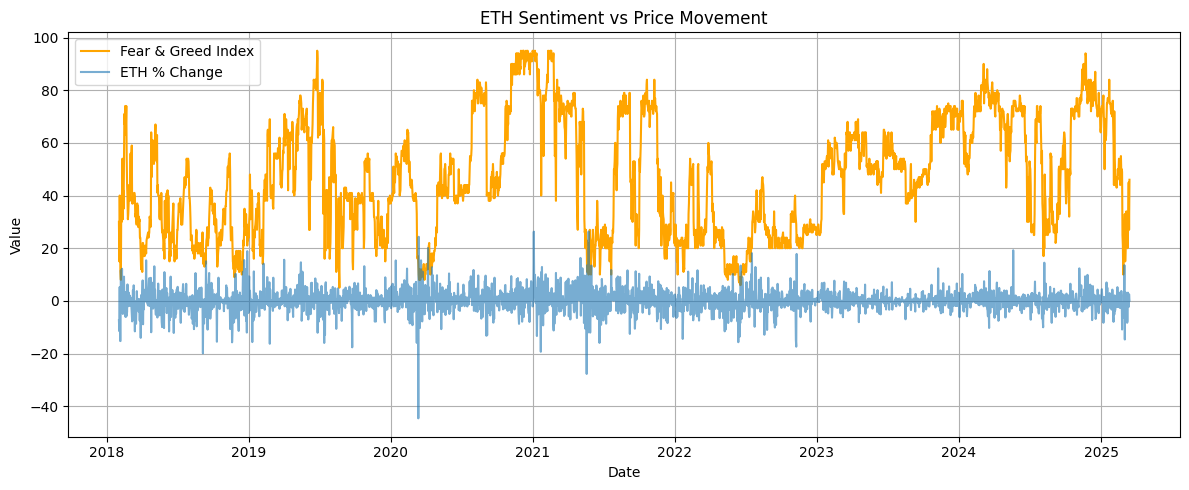


Processing DOGE

Summary of DOGE Raw:
Rows: 2991572
Columns: 12
Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

Summary of DOGE Transformed:
Rows: 2080
Columns: 10
Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'pct_change', 'volatility', 'fear_greed_index', 'lagged_sentiment']

Correlation for DOGE
Immediate:
                      fear_greed_index  sentiment_pct_change  pct_change  \
fear_greed_index              1.000000              0.042781    0.035815   
sentiment_pct_change          0.042781              1.000000   -0.038645   
pct_change                    0.035815             -0.038645    1.000000   
volatility                    0.097375             -0.038416    0.730531   

                      volatility  
fear_greed_index        0.097375  
sentiment_pct_change   -0.038416  
pct_change              0.730531  
volatility 

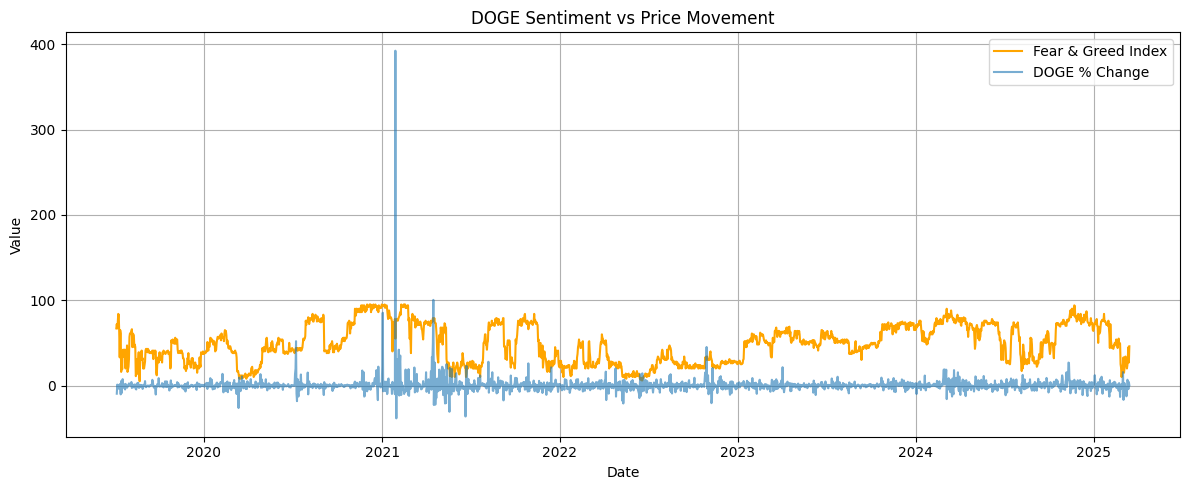


Processing SOL

Summary of SOL Raw:
Rows: 2413258
Columns: 12
Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

Summary of SOL Transformed:
Rows: 1677
Columns: 10
Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'pct_change', 'volatility', 'fear_greed_index', 'lagged_sentiment']

Correlation for SOL
Immediate:
                      fear_greed_index  sentiment_pct_change  pct_change  \
fear_greed_index              1.000000              0.049746    0.071322   
sentiment_pct_change          0.049746              1.000000   -0.045308   
pct_change                    0.071322             -0.045308    1.000000   
volatility                    0.040811             -0.048503    0.237295   

                      volatility  
fear_greed_index        0.040811  
sentiment_pct_change   -0.048503  
pct_change              0.237295  
volatility     

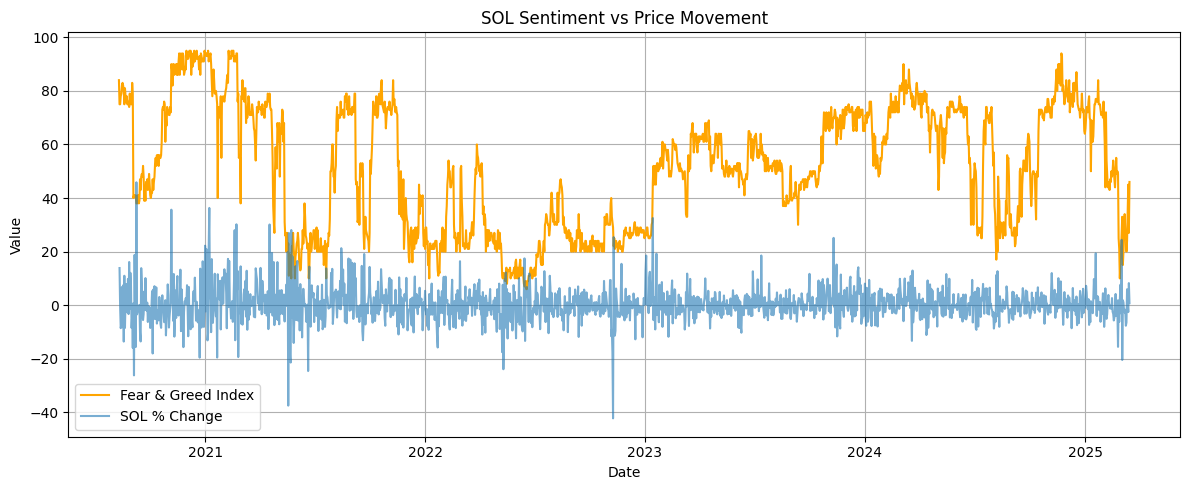

In [15]:
# Define the paths for each cryptocurrency's historical price CSV
coin_files = {
    "ETH": "/content/ETHUSDT.csv",
    "DOGE": "/content/DOGEUSDT.csv",
    "SOL": "/content/SOLUSDT.csv"
}

# Extract sentiment data from Fear & Greed Index API
sentiment_df = extract_fear_greed()

# Open SQLite connection to store outputs
conn = sqlite3.connect("crypto_sentiment.sqlite")

# Process each cryptocurrency one at a time
for symbol, path in coin_files.items():
    try:
        print(f"\nProcessing {symbol}")

        # Load raw crypto CSV data
        price_df = load_price_data(path)

        # Summarize raw input data
        summarize_df(price_df, f"{symbol} Raw")

        transformed_df = transform_data(price_df, sentiment_df)
        # Skip if merged data is empty (no overlap in date ranges)
        if transformed_df.empty:
            continue

        # Summarize transformed dataset
        summarize_df(transformed_df, f"{symbol} Transformed")

        # Print correlation matrix: price vs sentiment
        correlation_report(transformed_df, symbol)

        # Save results to CSV, JSON, and SQLite
        save_outputs(transformed_df, symbol, conn)

        # Generate time-series plot for sentiment vs price movement
        plot_sentiment_vs_price(transformed_df, symbol)

    except Exception as e:
        # Error handling for each symbol
        print(f"Error processing {symbol}: {e}")

# Close database connection after all assets are processed
conn.close()


In [17]:

API_KEY = "..."  # <-- Replace with your actual key


In [18]:
# Fetch 5 years of historical daily price data for a given ETF symbol
def get_etf_history(symbol):
    url = f"https://yfapi.net/v8/finance/chart/{symbol}"
    headers = {"x-api-key": API_KEY}
    params = {
        "range": "5y",         # Retrieve 5 years of data
        "interval": "1d",      # Daily intervals
        "region": "US"
    }

    # Send GET request to Yahoo Finance API
    res = requests.get(url, headers=headers, params=params).json()

    try:
        # Extract timestamp and closing prices
        timestamps = res["chart"]["result"][0]["timestamp"]
        closes = res["chart"]["result"][0]["indicators"]["quote"][0]["close"]
    except Exception:
        print(f"Could not retrieve data for {symbol}")
        return pd.DataFrame()

    # Construct DataFrame and convert UNIX timestamp to datetime
    df = pd.DataFrame({
        "date": pd.to_datetime(timestamps, unit="s"),
        "close": closes
    }).dropna()

    # Add ETF symbol as a column for context
    df["symbol"] = symbol
    return df


In [19]:
# Load local CSVs (already in minutes), convert to datetime, floor to daily, and aggregate
def load_price_data(filepath):
    df = pd.read_csv(filepath)

    # Rename column if needed
    if "timestamp" in df.columns:
        df = df.rename(columns={"timestamp": "date"})

    df["date"] = pd.to_datetime(df["date"])

    # Floor timestamps to daily granularity
    df["date"] = df["date"].dt.floor("d")

    # Aggregate OHLCV (Open, High, Low, Close, Volume) to daily
    daily = df.groupby("date").agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum"
    }).reset_index()

    return daily


In [20]:
# Merge daily crypto and ETF data, compute daily % change and correlation
def correlate_crypto_vs_macro(crypto_df, macro_df, crypto_label, macro_label):
    # Sort by date and rename for clarity
    crypto_df = crypto_df.sort_values("date").rename(columns={"close": "crypto_close"})
    macro_df = macro_df.sort_values("date").rename(columns={"close": "macro_close"})

    # Calculate daily % changes for both
    crypto_df["crypto_pct_change"] = crypto_df["crypto_close"].pct_change(fill_method=None) * 100
    macro_df["macro_pct_change"] = macro_df["macro_close"].pct_change(fill_method=None) * 100

    # Merge using the closest previous ETF date (within 1 day)
    merged = pd.merge_asof(
        crypto_df, macro_df, on="date",
        direction="backward",
        tolerance=pd.Timedelta("1D")
    ).dropna(subset=["crypto_pct_change", "macro_pct_change"])

    #Error Handling
    if merged.empty:
        print(f"No overlapping data for {crypto_label} and {macro_label}")
        return pd.DataFrame()

    # Print correlation result
    print(f"\nCorrelation between {crypto_label} and {macro_label}:")
    print(merged[["crypto_pct_change", "macro_pct_change"]].corr())

    return merged


In [21]:
# Define local CSVs for cryptocurrency data
crypto_files = {
    "ETH": "/content/ETHUSDT.csv",
    "DOGE": "/content/DOGEUSDT.csv",
    "SOL": "/content/SOLUSDT.csv"
}

# Load all crypto CSVs into a dictionary
final_crypto_dfs = {}
for symbol, path in crypto_files.items():
    df = load_price_data(path)
    final_crypto_dfs[symbol] = df


In [22]:
# Load macroeconomic ETF data from Yahoo Finance
gold_df = get_etf_history("GLD")     # Gold ETF
oil_df = get_etf_history("USO")      # Oil ETF
sp500_df = get_etf_history("SPY")    # S&P 500 ETF

# Ensure all date columns are datetime
for df in [gold_df, oil_df, sp500_df]:
    df["date"] = pd.to_datetime(df["date"])


In [23]:
# Connect to SQLite DB
conn = sqlite3.connect("crypto_macro.sqlite")

# For each crypto, run correlation with each macro asset and store results
for symbol, df in final_crypto_dfs.items():
    df["date"] = pd.to_datetime(df["date"])  # extra safety

    # GOLD
    gold_result = correlate_crypto_vs_macro(df, gold_df, symbol, "Gold")
    if not gold_result.empty:
        table_name = f"{symbol.lower()}_vs_gold"
        gold_result.to_sql(table_name, conn, if_exists="replace", index=False)

    # OIL
    oil_result = correlate_crypto_vs_macro(df, oil_df, symbol, "Oil")
    if not oil_result.empty:
        table_name = f"{symbol.lower()}_vs_oil"
        oil_result.to_sql(table_name, conn, if_exists="replace", index=False)

    # SP500
    sp500_result = correlate_crypto_vs_macro(df, sp500_df, symbol, "SP500")
    if not sp500_result.empty:
        table_name = f"{symbol.lower()}_vs_sp500"
        sp500_result.to_sql(table_name, conn, if_exists="replace", index=False)

# Close database connection
conn.close()



Correlation between ETH and Gold:
                   crypto_pct_change  macro_pct_change
crypto_pct_change            1.00000          -0.02056
macro_pct_change            -0.02056           1.00000

Correlation between ETH and Oil:
                   crypto_pct_change  macro_pct_change
crypto_pct_change           1.000000         -0.011519
macro_pct_change           -0.011519          1.000000

Correlation between ETH and SP500:
                   crypto_pct_change  macro_pct_change
crypto_pct_change           1.000000         -0.041783
macro_pct_change           -0.041783          1.000000

Correlation between DOGE and Gold:
                   crypto_pct_change  macro_pct_change
crypto_pct_change           1.000000         -0.014413
macro_pct_change           -0.014413          1.000000

Correlation between DOGE and Oil:
                   crypto_pct_change  macro_pct_change
crypto_pct_change           1.000000          0.012154
macro_pct_change            0.012154          1.000000